# 聚类

## 1.创建对象

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('K_means').getOrCreate()

## 2.读取数据集

In [2]:
df = spark.read.csv('data/iris_dataset.csv', inferSchema=True, header=True)

## 3.数据分析

In [3]:
print((df.count(), len(df.columns)))

(150, 5)


In [4]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [5]:
from pyspark.sql.functions import rand
df.orderBy(rand()).show(10, False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|7.2         |3.0        |5.8         |1.6        |virginica |
|5.7         |3.8        |1.7         |0.3        |setosa    |
|7.7         |3.0        |6.1         |2.3        |virginica |
|6.3         |2.9        |5.6         |1.8        |virginica |
|5.8         |2.7        |4.1         |1.0        |versicolor|
|5.0         |2.0        |3.5         |1.0        |versicolor|
|6.4         |3.2        |4.5         |1.5        |versicolor|
|5.2         |2.7        |3.9         |1.4        |versicolor|
|6.4         |2.8        |5.6         |2.2        |virginica |
|6.5         |3.0        |5.8         |2.2        |virginica |
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [6]:
df.groupBy('species').count().orderBy('count').show(10, False)

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|versicolor|50   |
|setosa    |50   |
+----------+-----+



## 4.特征工程

In [7]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
input_cols = ['sepal_length','sepal_width','petal_length','petal_width']
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

## 5.构建模型

In [8]:
from pyspark.ml.clustering import KMeans
errors = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(final_data)
    intra_distance = model.computeCost(final_data)
    errors.append(intra_distance)

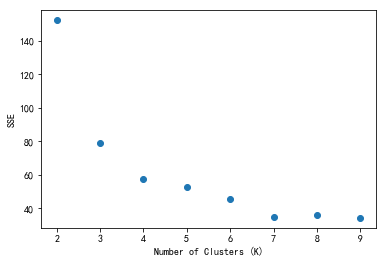

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
cluster_number = range(2, 10)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.scatter(cluster_number, errors)
plt.show()

In [12]:
kmeans = KMeans(featuresCol='features', k = 3)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   62|
|         2|   38|
|         0|   50|
+----------+-----+



In [13]:
predictions = model.transform(final_data)
predictions.groupBy('species', 'prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
|    setosa|         0|   50|
| virginica|         1|   14|
|versicolor|         1|   48|
|versicolor|         2|    2|
+----------+----------+-----+



## 6.可视化

In [14]:
pandas_df = predictions.toPandas()
pandas_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
0,5.1,3.5,1.4,0.2,setosa,"[5.1, 3.5, 1.4, 0.2]",0
1,4.9,3.0,1.4,0.2,setosa,"[4.9, 3.0, 1.4, 0.2]",0
2,4.7,3.2,1.3,0.2,setosa,"[4.7, 3.2, 1.3, 0.2]",0
3,4.6,3.1,1.5,0.2,setosa,"[4.6, 3.1, 1.5, 0.2]",0
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]",0


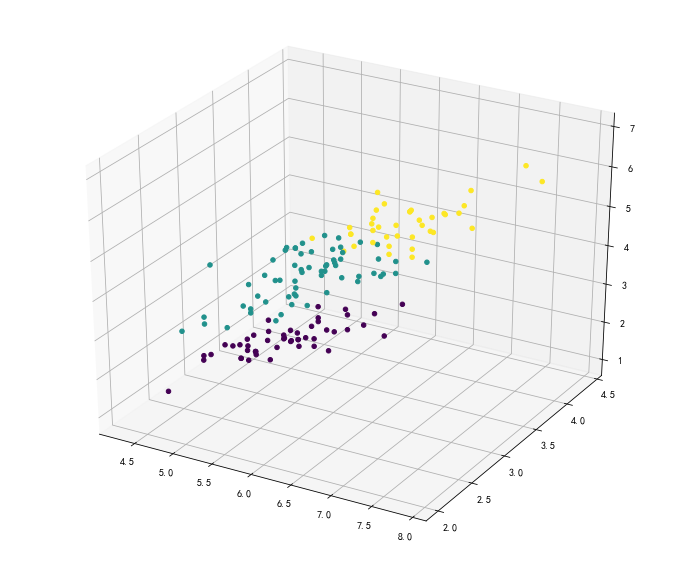

In [15]:
from mpl_toolkits.mplot3d import Axes3D
cluster_vis = plt.figure(figsize=(12,10)).gca(projection='3d')
cluster_vis.scatter(
    pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c = pandas_df.prediction, depthshade = False)
plt.show()